# Эволюционный поиск графов

В данном notebook фреймворк GOLEM используется для эволюционного поиска графов, наиболее схожих с каким-то целевым графом (случайно сгенерированным).

На базе этого блокнота можно поэкспериментировать с различными настройками оптимизатора и сравнить поведение алгоритма (сходимости, результата) на графиках.

*Примеры экспериментов:*
- Сравнить эффективность эволюционного оптимизатора`EvoGraphOptimizer` и случайного поиска `RandomMutationSearchOptimizer`;
- Сравнить скорость сходимости при различных настройках вероятностей мутации и кроссовера;
- Сравнить популяционную (`GeneticSchemeTypesEnum.generational`) и адаптивную схемы (`GeneticSchemeTypesEnum.parameter_free`) эволюционного алгоритма.
  Адаптивная схема автоматически подбирает вероятности мутации и кроссовера.

## Подготовка среды

### Локально
Следующие строчки нужны для локального запуска этого notebook из директории GOLEM и корректных импортов

In [ ]:
# This is needed for launching notebook from inside GOLEM directory
%pwd
%cd ../..
%pwd

E:\Documents\projects\all\GOLEM


'E:\\Documents\\projects\\all\\GOLEM'

### Google Colab
Из-за конфликтов версий некоторых пакетов в Google Colab нужно их обновить. Должна быть версия `PIL>=9.1.0`. Если нет -- обновите. ***После этого потребуется перезагрузка runtime***.

In [1]:
!pip install --force-reinstall pillow>=9.1.0  # There's a problem with Pillow on Google colab, see details here: https://forums.fast.ai/t/no-module-named-pil-image/96968/8
# !pip install --force-reinstall ipython~=7.9.0  # for solving Google Colab conflict; not necessary

In [1]:
import PIL
print(PIL.__version__)  # must be >= 9.1.0

9.4.0


## Установка пакетов

Простейший способ установить GOLEM -- это `pip install thegolem`.

Но мы установим последний GOLEM из ветки `dev`.

In [2]:
!pip install --upgrade --force-reinstall --no-cache-dir --quiet --no-warn-script-location https://github.com/aimclub/GOLEM/archive/dev.zip
!pip install numpy==1.22.4  # needed for compatibility with Google Colab
!pip install plotly

     - 504.0 kB 12.3 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 212.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 260.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 230.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 117.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 163.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 129.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 201.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 196.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Импортируем необходимые модули:

In [3]:
from datetime import timedelta, datetime
from itertools import cycle, zip_longest
from functools import partial
from typing import Type, Optional, Sequence, Tuple
from pprint import pprint

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from PIL import ImageColor

from examples.synthetic_graph_evolution.experiment import run_experiments
from examples.synthetic_graph_evolution.utils import draw_graphs_subplots, visualize_histories
from examples.synthetic_graph_evolution.generators import generate_labeled_graph
from golem.core.adapter.nx_adapter import BaseNetworkxAdapter
from golem.core.dag.verification_rules import has_no_self_cycled_nodes
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.base_mutations import MutationTypesEnum
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.objective import Objective
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams, GraphOptimizer
from golem.core.optimisers.opt_history_objects.opt_history import OptHistory
from golem.metrics.graph_metrics import *

## Определение задачи и оптимизатора

Определим основные настройки оптимизации:
- Размер и тип целевого графа:
  `gnp` -- это случайно растущий граф, склонный к кластеризации,
  а 20 -- это небольшой размер для быстрой оптимизации.
- Целевая функция, измеряющая некоторое "расстояние" до целевого графа
- Параметры алгоритма: набор мутаций и кроссовера, генетическая схема, вероятности
- Адаптер графов и правила верификации (ограничения на графы)

In [22]:
def run_search(graph_kind: str = 'gnp',
               graph_size: int = 30,
               optimizer_cls: Type[GraphOptimizer] = EvoGraphOptimizer,
               gp_params: Optional[GPAlgorithmParameters] = None,
               node_types: Sequence[str] = ('x',),
               timeout: Optional[timedelta] = timedelta(minutes=4),
               num_iterations: Optional[int] = 400):  
    
    # Generate target graph for optimization
    target_graph = generate_labeled_graph(graph_kind, graph_size, node_types)
    # Generate simple initial population with small graphs
    initial_graphs = [generate_labeled_graph('gnp', k+5, node_types) for k in range(5)]

    # Setup objective that measures some graph-theoretic similarity measure
    objective = Objective(
        quality_metrics={
            # 'sp_adj': partial(spectral_dist, target_graph, kind='adjacency'),
            'sp_lapl': partial(spectral_dist, target_graph, kind='laplacian'),
        },
        complexity_metrics={
            'graph_size': partial(size_diff, target_graph),
        },
        is_multi_objective=False
    )
    
    # Optimization parameters
    requirements = GraphRequirements(
        timeout=timeout,
        num_of_generations=num_iterations,
        early_stopping_iterations=None,
        history_dir=None,

        max_depth=graph_size,
        max_arity=graph_size,
    )
    
    gp_params = gp_params or GPAlgorithmParameters(
        pop_size=20,
        mutation_prob=0.8,
        crossover_prob=0.8,
        genetic_scheme_type=GeneticSchemeTypesEnum.generational,
        mutation_types=[
            MutationTypesEnum.single_add,
            MutationTypesEnum.single_drop,
            MutationTypesEnum.single_edge,
        ],
    )
    gp_params.multi_objective = objective.is_multi_objective
    
    graph_gen_params = GraphGenerationParams(
        adapter=BaseNetworkxAdapter(),
        rules_for_constraint=[has_no_self_cycled_nodes],
        available_node_types=node_types,
    )
    
    # Build and run the optimizer
    initial_graphs = graph_gen_params.adapter.adapt(initial_graphs)
    optimiser = optimizer_cls(objective, initial_graphs, requirements, graph_gen_params, gp_params)
    found_graphs = optimiser.optimise(objective)
    
    found_graphs = graph_gen_params.adapter.restore(found_graphs)
    best_graph = found_graphs[0]
    history = optimiser.history
   
    return best_graph, history, target_graph

Определим вспомогательные функции для визуализации историй и графов

In [29]:
def visualise_graphs(best_graph, history, target_graph):
    adapter = BaseNetworkxAdapter()
    best_graph = adapter.restore(best_graph)
    initial_graphs = adapter.restore(history.initial_assumptions)
    found_graphs = adapter.restore(history.final_choices)

    # Visualize results and optimization process
    print('Характеристики целевого графа:')
    pprint(nxgraph_stats(target_graph))
    print('\nХарактеристики найденного лучшего графа:')
    pprint(nxgraph_stats(best_graph))

    # Show target graph and best graph
    print('Целевой и лучший графы:')
    draw_graphs_subplots(target_graph, best_graph, size=8)
    # Show initial assumptions
    print('Начальное приближение:')
    draw_graphs_subplots(*initial_graphs[:6], size=6)
    if len(found_graphs) > 1:
      print('Лучшие графы:')
      # Show final results
      draw_graphs_subplots(*found_graphs[:6], size=8)

## Запуск экспериментов

### Эксперимент 1: сравнение случайного поиска и эволюции

Мы можем увидеть, что эволюционный алгоритм показывает лучшеие результаты и достигает их за меньшее время. Это происходит за счет более целенаправленного поиска и обмена информацией между членами популяции (за счет кроссовера). Запустим и проверим.

Запустим оптимизатор случайного поиска

In [ ]:
from golem.core.optimisers.random.random_mutation_optimizer import RandomMutationSearchOptimizer
from golem.core.optimisers.random.random_search import RandomSearchOptimizer

best_graph, history, target_graph = \
    run_search(graph_kind='gnp', graph_size=30, optimizer_cls=RandomMutationSearchOptimizer, num_iterations=500)

Запустим эволюционный оптимизатор

In [ ]:
best_graph2, history2, target_graph2 = \
    run_search(graph_kind='gnp', graph_size=30, optimizer_cls=EvoGraphOptimizer)

Визуализиуем графики истории оптимизации

INFO:root:FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


2023-03-17 13:40:10,308 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


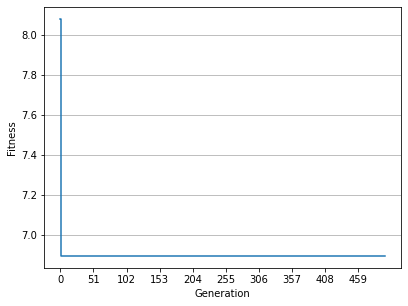

In [23]:
# Show optimization history
history.show.fitness_line()

INFO:root:FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


2023-03-17 13:34:55,384 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


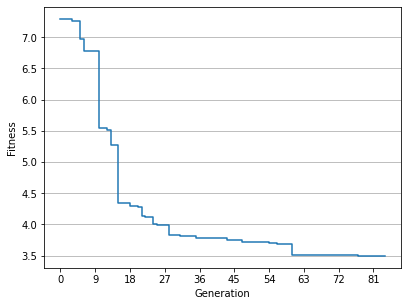

In [13]:
# Show optimization history
history2.show.fitness_line()

Визуализируем целевой граф, начальное приближеие и найденные графы

Характеристики целевого графа:
{'avg_clustering': 0.023,
 'degrees_hist': [0, 3, 9, 11, 5, 2],
 'degrees_hist_norm': array([0.  , 0.19, 0.58, 0.71, 0.32, 0.13]),
 'num_edges': 42,
 'num_nodes': 30}

Характеристики найденного лучшего графа:
{'avg_clustering': 0.0,
 'degrees_hist': [2],
 'degrees_hist_norm': array([1.]),
 'num_edges': 0,
 'num_nodes': 2}
Целевой и лучший графы:


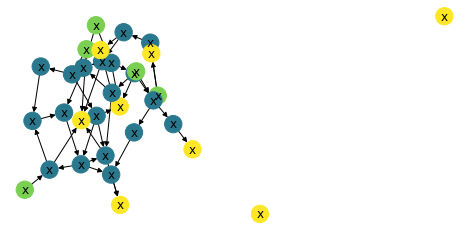

Начальное приближение:


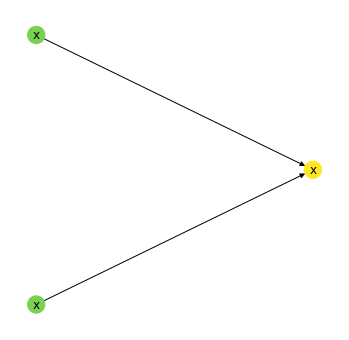

In [30]:
# Visualise initial and final populations
visualise_graphs(best_graph, history, target_graph)

Характеристики целевого графа:
{'avg_clustering': 0.059,
 'degrees_hist': [0, 3, 5, 6, 5, 8, 1, 1, 1],
 'degrees_hist_norm': array([0.  , 0.24, 0.39, 0.47, 0.39, 0.63, 0.08, 0.08, 0.08]),
 'num_edges': 56,
 'num_nodes': 30}

Характеристики найденного лучшего графа:
{'avg_clustering': 0.028,
 'degrees_hist': [1, 6, 11, 4, 6, 2],
 'degrees_hist_norm': array([0.07, 0.41, 0.75, 0.27, 0.41, 0.14]),
 'num_edges': 37,
 'num_nodes': 30}
Целевой и лучший графы:


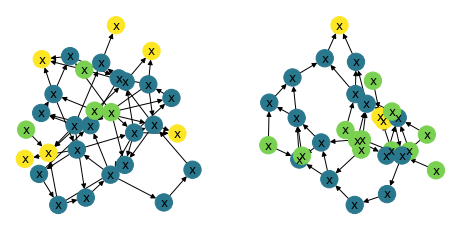

Начальное приближение:


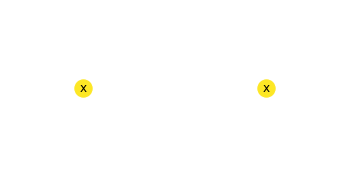

In [31]:
# Visualise initial and final populations
visualise_graphs(best_graph2, history2, target_graph2)

### Эксперимент 2: Влияние эволюционных операторов и их вероятностей

Одной из ключевых идей работы генетических алгоритмов является использование операторов **мутации**, **селекции** и **кроссовера**. При помощи верно подобранных операций и их вероятностей можно ускорить процесс схождения функции к оптимуму.

Далее мы наглядно убедимся в этом. В примерах выше были использованы все возможные операторы. Теперь попробуем запустить алгоритм используя только конкретные и посмотрим на их влияния на процесс оптимизации.

Запустим процесс оптимизации *без оператора кроссовера*

In [ ]:
gp_params = GPAlgorithmParameters(
    mutation_prob=0.8,
    crossover_prob=0.8,
    genetic_scheme_type=GeneticSchemeTypesEnum.generational,
    mutation_types=[
        MutationTypesEnum.single_add,
        MutationTypesEnum.single_drop,
        MutationTypesEnum.single_edge,
    ],
    crossover_types=[CrossoverTypesEnum.none]
)
best_graph, history, target_graph = \
    run_search(graph_kind='gnp', graph_size=30, gp_params=gp_params)

Построим графики, сравнив с первым запуском эволюционного оптимизатора

In [ ]:
history2.show.fitness_line()

In [ ]:
history.show.fitness_line()

Попробуем запустить оптимизатор с меньшими вероятностями мутации и кроссовера. Замедлится ли эволюция или станет более стабильной? В каждом случае нужно подбирать подходящие значения. Но диапазон "подходящих" значений вероятностей, как показывает практиа области, достаточн широк. В некоторых же случаях слишком большие вероятности не дадут оптимизатору сойтись к оптимальному решению.

In [ ]:
gp_params = GPAlgorithmParameters(
    mutation_prob=0.8,
    crossover_prob=0.8,
    genetic_scheme_type=GeneticSchemeTypesEnum.parameter_free,
    mutation_types=[
        MutationTypesEnum.single_add,
        MutationTypesEnum.single_drop,
        MutationTypesEnum.single_edge,
    ],
)
best_graph, history, target_graph = \
    run_search(graph_kind='gnp', graph_size=30, gp_params=gp_params)

In [ ]:
history1.show.fitness_line()

In [ ]:
history.show.fitness_line()

Для того, чтобы избежать ручной подбор вероятностей, существуют адаптивне схемы эволюции. Адаптивная схема автоматически изменяет вероятности мутации и кроссовера в зависимости от успеха сходимости.

Запустим оптимизатор с адаптивной эволюционной схемой. 

In [ ]:
gp_params = GPAlgorithmParameters(
    mutation_prob=0.8,
    crossover_prob=0.8,
    genetic_scheme_type=GeneticSchemeTypesEnum.parameter_free,
    mutation_types=[
        MutationTypesEnum.single_add,
        MutationTypesEnum.single_drop,
        MutationTypesEnum.single_edge,
    ],
)
best_graph, history, target_graph = \
    run_search(graph_kind='gnp', graph_size=30, gp_params=gp_params)

Посмотрим на результаты

In [ ]:
history2.show.fitness_line()

In [ ]:
history.show.fitness_line()